In [4]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space',
             'comp.sys.ibm.pc.hardware', 'sci.crypt']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)

cv = CountVectorizer(token_pattern="[\w']{3,}", stop_words='english',
                    max_features=2000, min_df=5, max_df=0.5)
review_cv = cv.fit_transform(newsgroups_train.data)

In [6]:
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
np.set_printoptions(precision=3)

lda = LatentDirichletAllocation(n_components=10,
                              max_iter=5,
                              topic_word_prior=0.1,
                              doc_topic_prior=1.0,
                              learning_method='online',
                              n_jobs=-1,
                              random_state=0)
review_topics = lda.fit_transform(review_cv)

In [7]:
print('Shape of review_topics:', review_topics.shape)
print('Sample of review_topics:', review_topics[0])

gross_topic_weights = np.mean(review_topics, axis=0)
print('Sum of topic weights of documents:', gross_topic_weights)
print('Shape of topic word distribution:', lda.components_.shape)

Shape of review_topics: (3219, 10)
Sample of review_topics: [0.903 0.007 0.027 0.008 0.007 0.008 0.007 0.007 0.007 0.018]
Sum of topic weights of documents: [0.087 0.083 0.085 0.115 0.115 0.126 0.098 0.072 0.07  0.148]
Shape of topic word distribution: (10, 2000)


In [8]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(
            ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]))
        print()
print_top_words(lda, cv.get_feature_names_out(), 10)

Topic #0: com, morality, keith, article, sgi, think, sandvik, objective, caltech, moral

Topic #1: image, file, graphics, files, ftp, available, software, use, data, mail

Topic #2: space, nasa, access, launch, earth, orbit, shuttle, digex, lunar, satellite

Topic #3: article, com, just, don't, like, i'm, nntp, university, host, posting

Topic #4: key, clipper, chip, encryption, com, government, law, keys, use, escrow

Topic #5: scsi, com, bit, ibm, bus, know, windows, thanks, card, university

Topic #6: host, gov, nntp, posting, university, distribution, nasa, ___, world, com

Topic #7: drive, com, disk, hard, controller, drives, dos, tape, floppy, problem

Topic #8: key, public, message, faq, mail, pgp, des, group, uni, ripem

Topic #9: god, people, don't, jesus, believe, just, does, say, think, know



In [12]:
import matplotlib.pyplot as plt
def test_perplexity(cv, start=10, end=30, max_iter=5, topic_word_prior=0.1,
                   doc_topic_prior=1.0):
    iter_num = []
    per_value = []
    for i in range(start, end+1):
        lda = LatentDirichletAllocation(n_components=i, max_iter=max_iter,
                                       topic_word_prior=topic_word_prior,
                                       doc_topic_prior=doc_topic_prior,
                                       learning_method='batch', n_jobs=-1,
                                       random_state=7)
        lda.fit(cv)
        iter_num.append(i)
        per_value.append(lda.perplexity(cv))
        
    plt.plot(iter_num, per_value, 'g-')
    plt.show()
    return start + per_value.index(min(per_value))

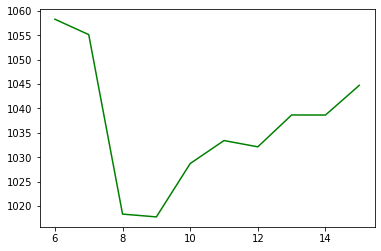

n_components with minimum perplexity: 9


In [13]:
print('n_components with minimum perplexity:',
     test_perplexity(review_cv, start=6, end=15))

In [16]:
lda = LatentDirichletAllocation(n_components=8, max_iter=20, topic_word_prior=0.1,
                               doc_topic_prior=1.0, learning_method='batch',
                               n_jobs=-1, random_state=7)
review_topics = lda.fit_transform(review_cv)
print_top_words(lda, cv.get_feature_names_out(), 10)

Topic #0: image, graphics, available, file, mail, ftp, data, information, files, software

Topic #1: posting, nntp, host, com, university, gov, distribution, article, nasa, ___

Topic #2: com, keith, article, morality, think, caltech, sgi, don't, objective, posting

Topic #3: com, jesus, article, know, god, just, don't, people, good, sandvik

Topic #4: people, god, does, don't, think, say, believe, just, like, way

Topic #5: drive, scsi, card, com, disk, ide, controller, hard, bus, use

Topic #6: space, nasa, access, launch, moon, year, article, digex, just, earth

Topic #7: key, encryption, clipper, chip, com, government, keys, use, security, public



In [17]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
cachedStopWords = stopwords.words('english')
RegTok = RegexpTokenizer("[\w']{3,}")
english_stops = set(stopwords.words('english'))

def tokenizer(text):
    tokens = RegTok.tokenize(text.lower())
    words = [word for word in tokens if (word not in english_stops) and len(word) > 2]
    return words

texts = [tokenizer(news) for news in newsgroups_train.data]

In [18]:
from gensim.corpora.dictionary import Dictionary

dictionary = Dictionary(texts)
print('Number of initial unique words in documents:', len(dictionary))

dictionary.filter_extremes(keep_n=2000, no_below=5, no_above=0.5)
print('Number of unique words after removing rare and common words:', len(dictionary))

corpus = [dictionary.doc2bow(text) for text in texts]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of initial unique words in documents: 46466
Number of unique words after removing rare and common words: 2000
Number of unique tokens: 2000
Number of documents: 3219


In [19]:
from gensim.models import LdaModel
num_topics = 8
passes = 5
model = LdaModel(corpus=corpus, id2word=dictionary,
                passes=passes, num_topics=num_topics, random_state=7)
model.print_topics(num_words=10)

[(0,
  '0.013*"com" + 0.012*"would" + 0.010*"article" + 0.010*"card" + 0.009*"nntp" + 0.009*"host" + 0.009*"posting" + 0.008*"system" + 0.008*"keith" + 0.008*"university"'),
 (1,
  '0.017*"god" + 0.012*"one" + 0.011*"people" + 0.009*"would" + 0.009*"jesus" + 0.008*"com" + 0.008*"say" + 0.006*"christian" + 0.006*"bible" + 0.006*"believe"'),
 (2,
  '0.031*"com" + 0.027*"posting" + 0.026*"host" + 0.026*"nntp" + 0.019*"access" + 0.015*"article" + 0.014*"university" + 0.012*"digex" + 0.010*"net" + 0.010*"cwru"'),
 (3,
  '0.032*"space" + 0.018*"nasa" + 0.010*"gov" + 0.007*"orbit" + 0.006*"research" + 0.006*"earth" + 0.006*"launch" + 0.005*"first" + 0.005*"shuttle" + 0.005*"data"'),
 (4,
  '0.015*"would" + 0.014*"people" + 0.011*"com" + 0.010*"one" + 0.008*"like" + 0.007*"get" + 0.007*"article" + 0.007*"government" + 0.007*"think" + 0.007*"right"'),
 (5,
  '0.022*"key" + 0.015*"encryption" + 0.013*"chip" + 0.013*"clipper" + 0.010*"com" + 0.009*"use" + 0.008*"keys" + 0.008*"system" + 0.007*"dr

In [22]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

lda_viz = gensimvis.prepare(model, corpus, dictionary)
lda_viz

C:\Users\user\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.167620  0.042053       1        1  18.717841
5      0.068452  0.131736       2        1  16.306804
7      0.124927  0.016658       3        1  14.812815
4     -0.075573  0.033361       4        1  13.429953
3      0.107848  0.001626       5        1  12.447911
0      0.023261 -0.083507       6        1  10.405441
6     -0.084520 -0.007936       7        1   8.150994
2      0.003225 -0.133990       8        1   5.728240, topic_info=        Term         Freq        Total Category  logprob  loglift
538    space  1533.000000  1533.000000  Default  30.0000  30.0000
834      key  1300.000000  1300.000000  Default  29.0000  29.0000
20       com  3703.000000  3703.000000  Default  28.0000  28.0000
200      god  1153.000000  1153.000000  Default  27.0000  27.0000
70   posting  1732.000000  1732.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
289     like   127.851479  1663.484408   Topic8  -5.0142   0.2940
92     think   119.582174  1329.764911   Topic8  -5.0810   0.4510
116   anyone   103.983817   744.583694   Topic8  -5.2208   0.8912
304     know   101.014797  1486.397714   Topic8  -5.2498   0.1709
188     case    89.707026   514.263847   Topic8  -5.3685   1.1136

[503 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1359      2  0.081630      128
1359      3  0.853971      128
1359      4  0.018838      128
1359      5  0.037675      128
153       1  0.055294     1993
...     ...       ...      ...
704       5  0.007844      zoo
704       6  0.972610      zoo
704       8  0.007844      zoo
705       4  0.014601  zoology
705       6  0.978299  zoology

[2103 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 8, 5, 4, 1, 7, 3])